# 1. Load packages

In [1]:
import os, sys
sys.path.append('analysis-tools')
from analysis_tools.common.utils import *
from analysis_tools import utils, random, eda

# 2. Load dataset

In [2]:
train = pd.read_csv('../../data/train_data.csv')
test = train.query('Day >= 199')
train = train.query('Day < 199')

# 3. Generate datetime

In [3]:
def generate_datetime(data, start_date=datetime.datetime(2020, 12, 31)):
    data = copy(data)
    data['Day_tmp'] = (start_date + pd.to_timedelta(data['Day'], unit='day')).astype('string')
    data['Date'] = pd.to_datetime(data.apply(lambda row: f"{row['Day_tmp']} {row['Tmstamp']}:00", axis='columns'))
    for turbID in data['TurbID'].unique():
        d = data[data['TurbID'] == turbID]
        assert d['Date'].is_monotonic_increasing, "Data should be sorted"
        data.loc[data['TurbID'] == turbID, 'Time'] = 1 + np.arange(len(d))
    data.drop(columns=['Day_tmp'], inplace=True)
    data['Time'] = data['Time'].astype('int32')
    return data.reset_index(drop=True)

In [4]:
train1 = generate_datetime(train)

# 4. Mark abnormal Patv

- 특정 시간에 측정되지 않은 경우, 해당 Patv에 대하여 Error = 0
- 특정 시간에 측정된 Feature의 값이 Patv ≤ 0 and Wspd > 2.5인 경우, Patv 에 대하여 Error = 0
- 특정 시간에 측정된 Feature의 값이 Pab1 > 89° or Pab2 > 89° or Pab3 > 89°인 경우, Patv에 대하여 Error = 0
- 특정 시간에 측정된 Feature의 값이 Ndir > 720° or Ndir < -720°인 경우 Patv에 대하여 Error = 0
- 특정 시간에 측정된 Feature의 값이 Wdir > 180° or Wdir < -180°인 경우, Patv에 대하여 Error = 0

In [5]:
def get_idxs_abnormal(data):
    cond1 = (data['Patv'] <= 0) & (data['Wspd'] > 2.5)
    cond2 = (data['Pab1'] > 89) | (data['Pab2'] > 89) | (data['Pab3'] > 89)
    cond3 = (data['Wdir'] < -180) | (data['Wdir'] > 180) | (data['Ndir'] < -720) | (data['Ndir'] > 720)
    cond4 = data['Patv'].isnull()
    cond  = cond1 | cond2 | cond3 | cond4
    return np.where(cond)[0], np.where(cond1)[0], np.where(cond2)[0], np.where(cond3)[0], np.where(cond4)[0]

In [6]:
def mark_abnormal_Patv(data):
    data = copy(data)
    data['Abnormal'] = 0
    data[[f'Abnormal_{i}' for i in [1, 2, 3, 4]]] = 0
    idxs_full, idxs_1, idxs_2, idxs_3, idxs_4 = get_idxs_abnormal(data)
    for num, i in enumerate([idxs_1, idxs_2, idxs_3, idxs_4], start=1):
        data.loc[data.iloc[i].index, f'Abnormal_{num}'] = 1
    data.loc[data.iloc[idxs_full].index, 'Abnormal'] = 1
    
    # Plot
    fig, axes = plt.subplots(5, figsize=(40, 8))
    for ax, col in zip(axes, ['Abnormal'] + [f'Abnormal_{i}' for i in [1, 2, 3, 4]]):
        sns.boxplot(x='Patv', y=col, data=data, orient='h', ax=ax);
    for ax in axes[:-1]:
        ax.set_xticklabels([])
        ax.set_xlabel(None)        

    # Adjust Patv
    data['Patv'] = data['Patv'].where(data['Abnormal_2'] == 0, 0)
    data['Patv'] = data['Patv'].where(data['Abnormal_3'] == 0, 0)

    data['Ndir'] = np.clip(data['Ndir'], -720, 720)
    data['Wdir'] = np.clip(data['Wdir'], -180, 180)
    for i in [1, 2, 3]:
        data[f'Pab{i}'] = np.clip(data[f'Pab{i}'], 0, 89)
    
    return data

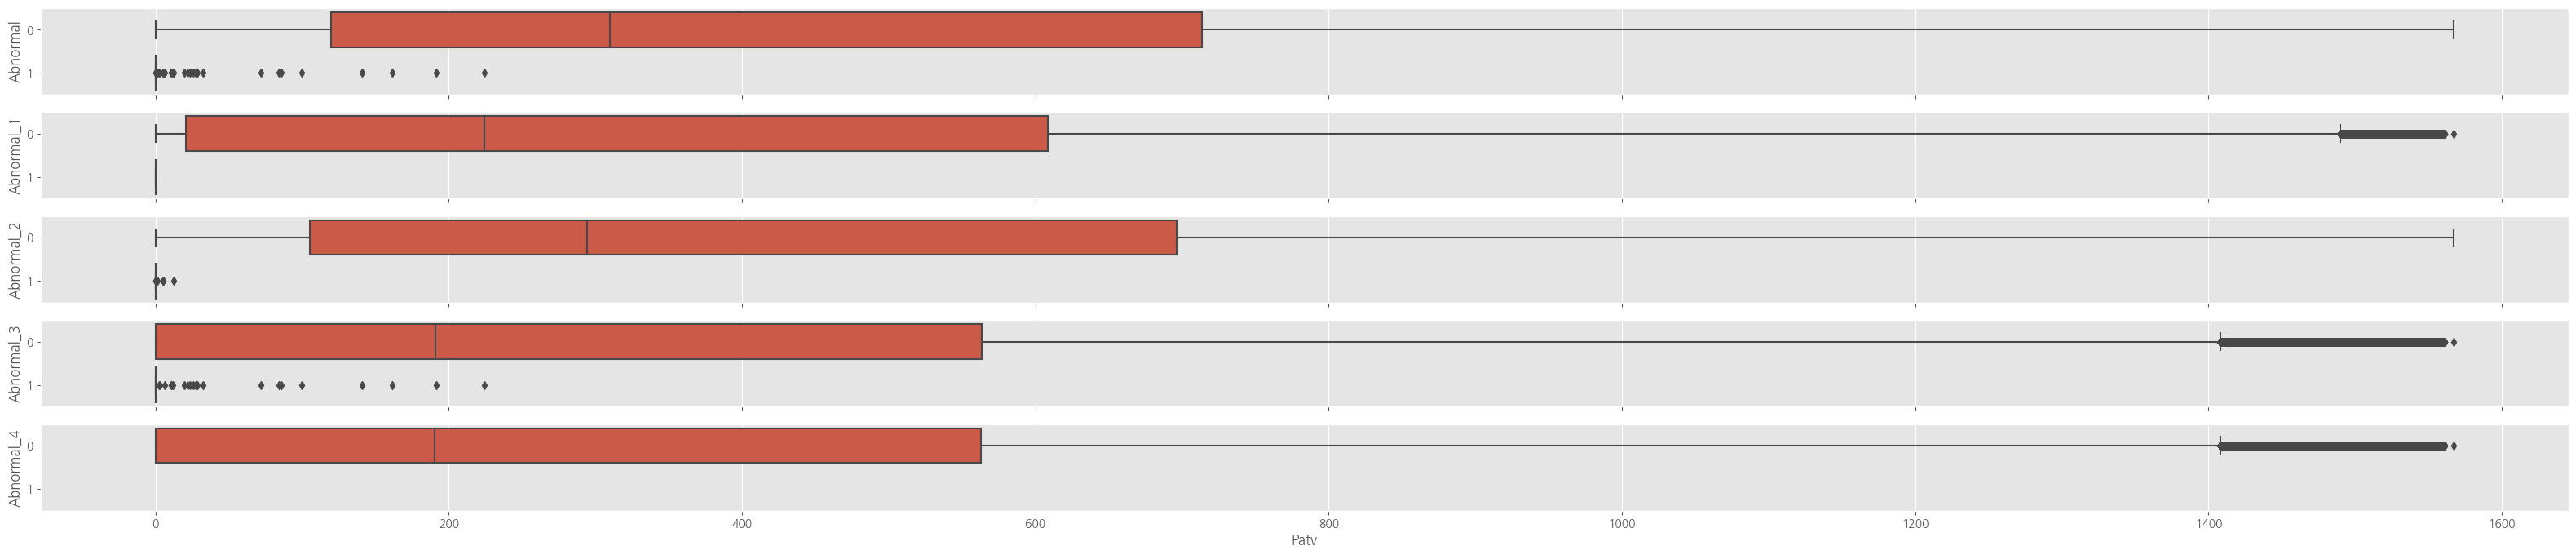

In [7]:
train2 = mark_abnormal_Patv(train1)

In [8]:
def split_abnormal(data):
    drop_cols = [col for col in data if 'Abnormal' in col]
    data_normal   = data[data['Abnormal'] != 1].drop(columns=drop_cols)
    data_abnormal = data[data['Abnormal'] == 1].drop(columns=drop_cols)
    return data_normal, data_abnormal

In [9]:
train2_normal, train2_abnormal = split_abnormal(train2)

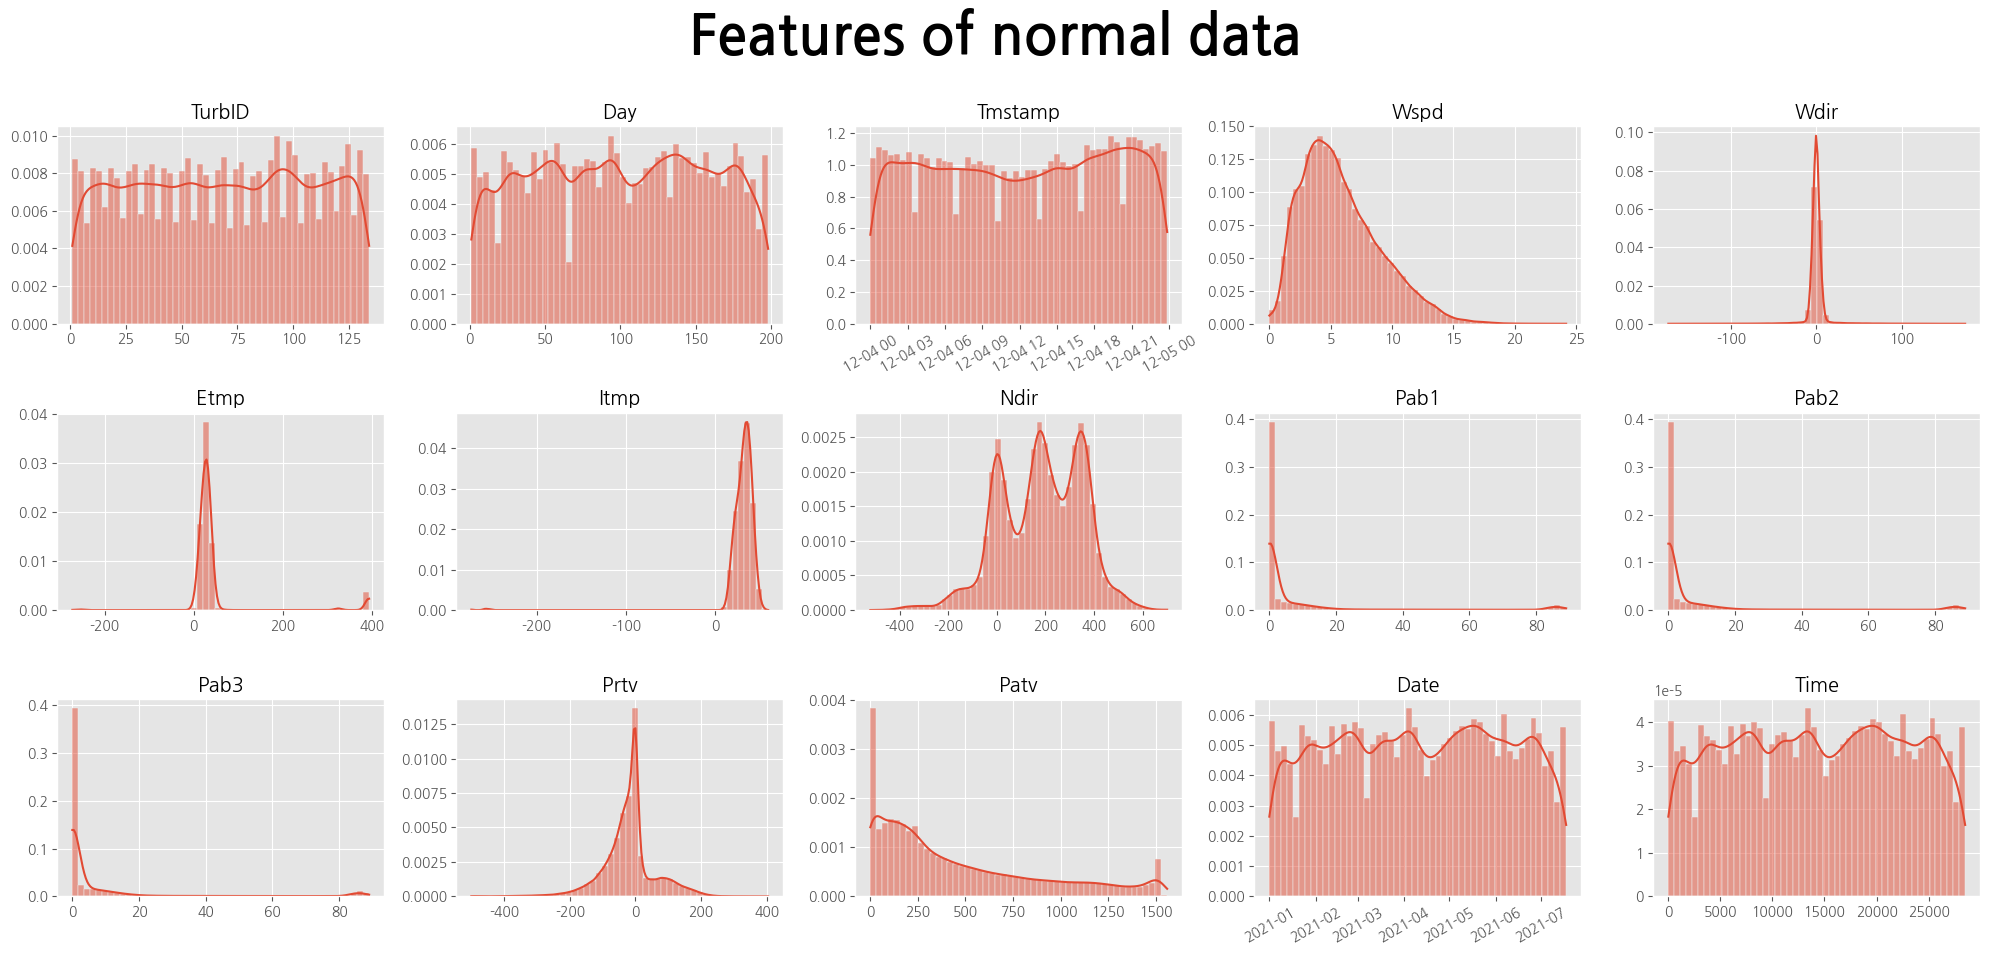

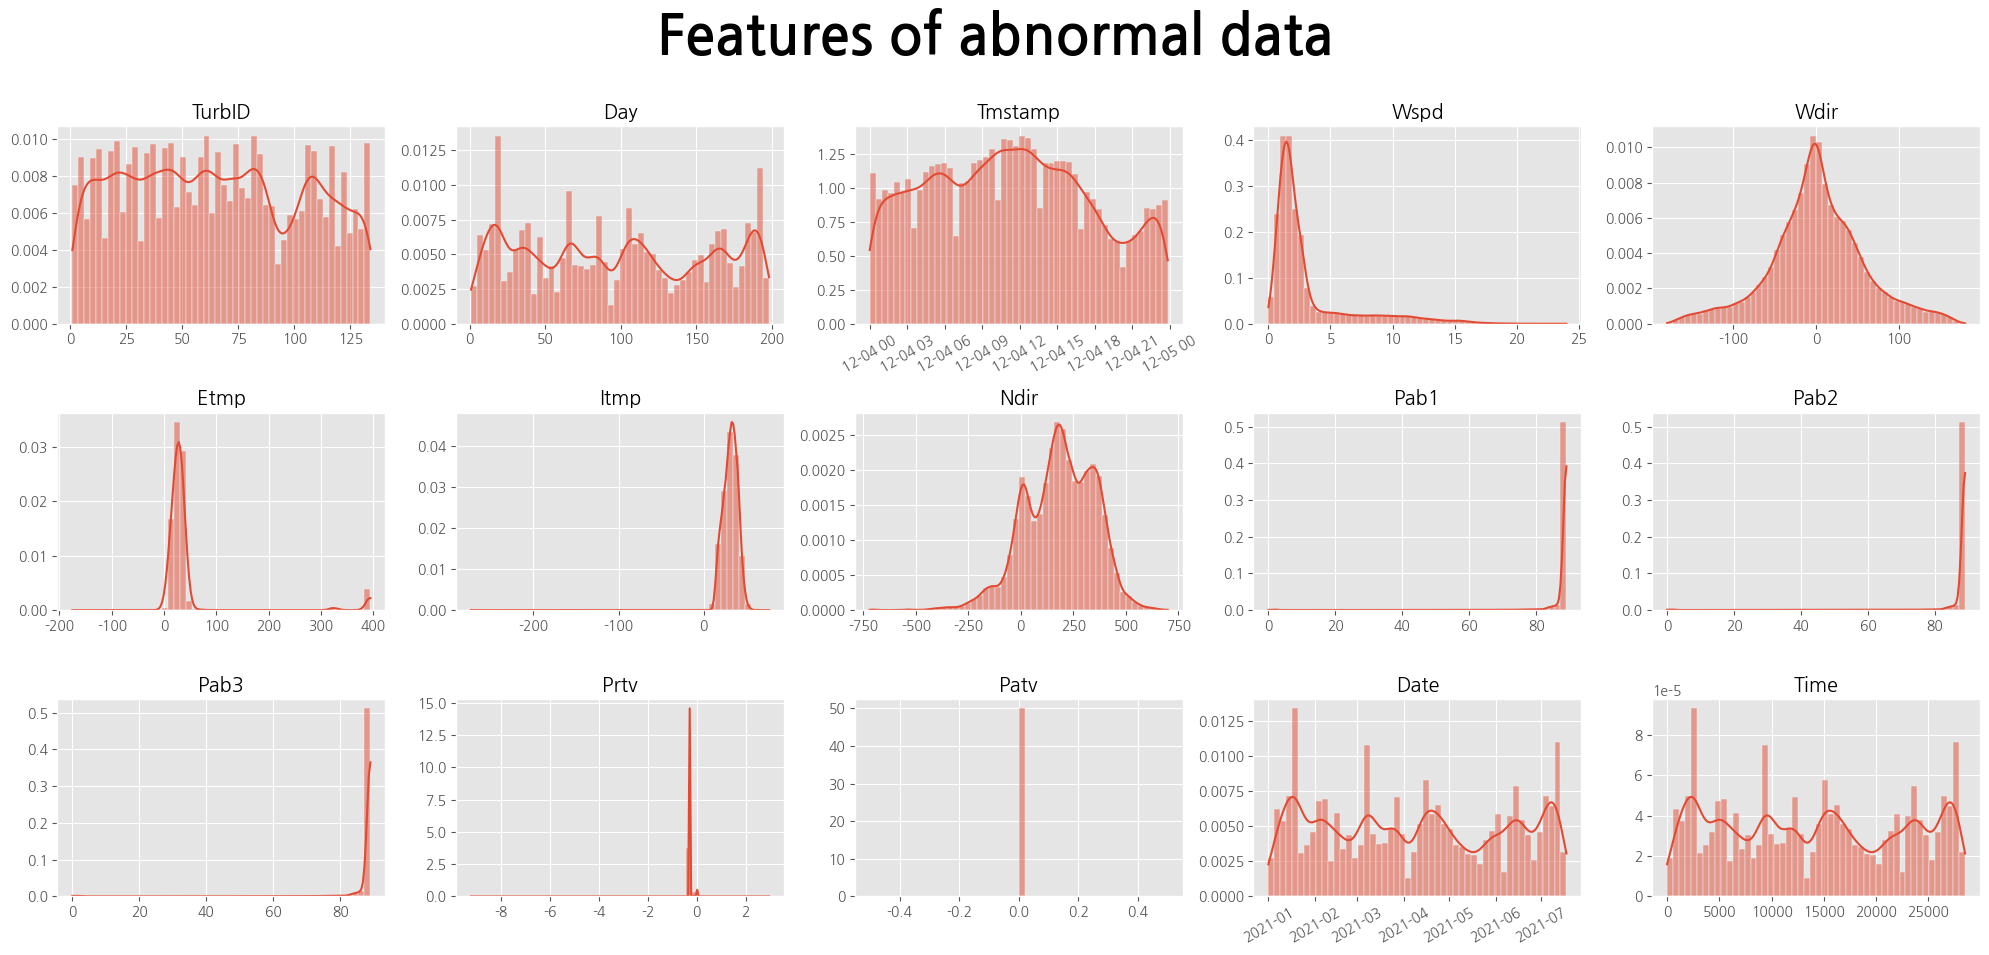

In [10]:
eda.plot_features(train2_normal.sample(100000), figsize=(20, 10), title='Features of normal data')
eda.plot_features(train2_abnormal.sample(100000), figsize=(20, 10), title='Features of abnormal data')

- Abnormal data는 대부분 pab(날개 각도)가 20도 이상인 것이 보이며, Patv(발전량)이 0인 경우가 대부분
- 풍력 발전에서 터빈의 날개 각도가 바람을 제대로 받을 수 있는 각도여야 한다는 사실을 알 수 있음

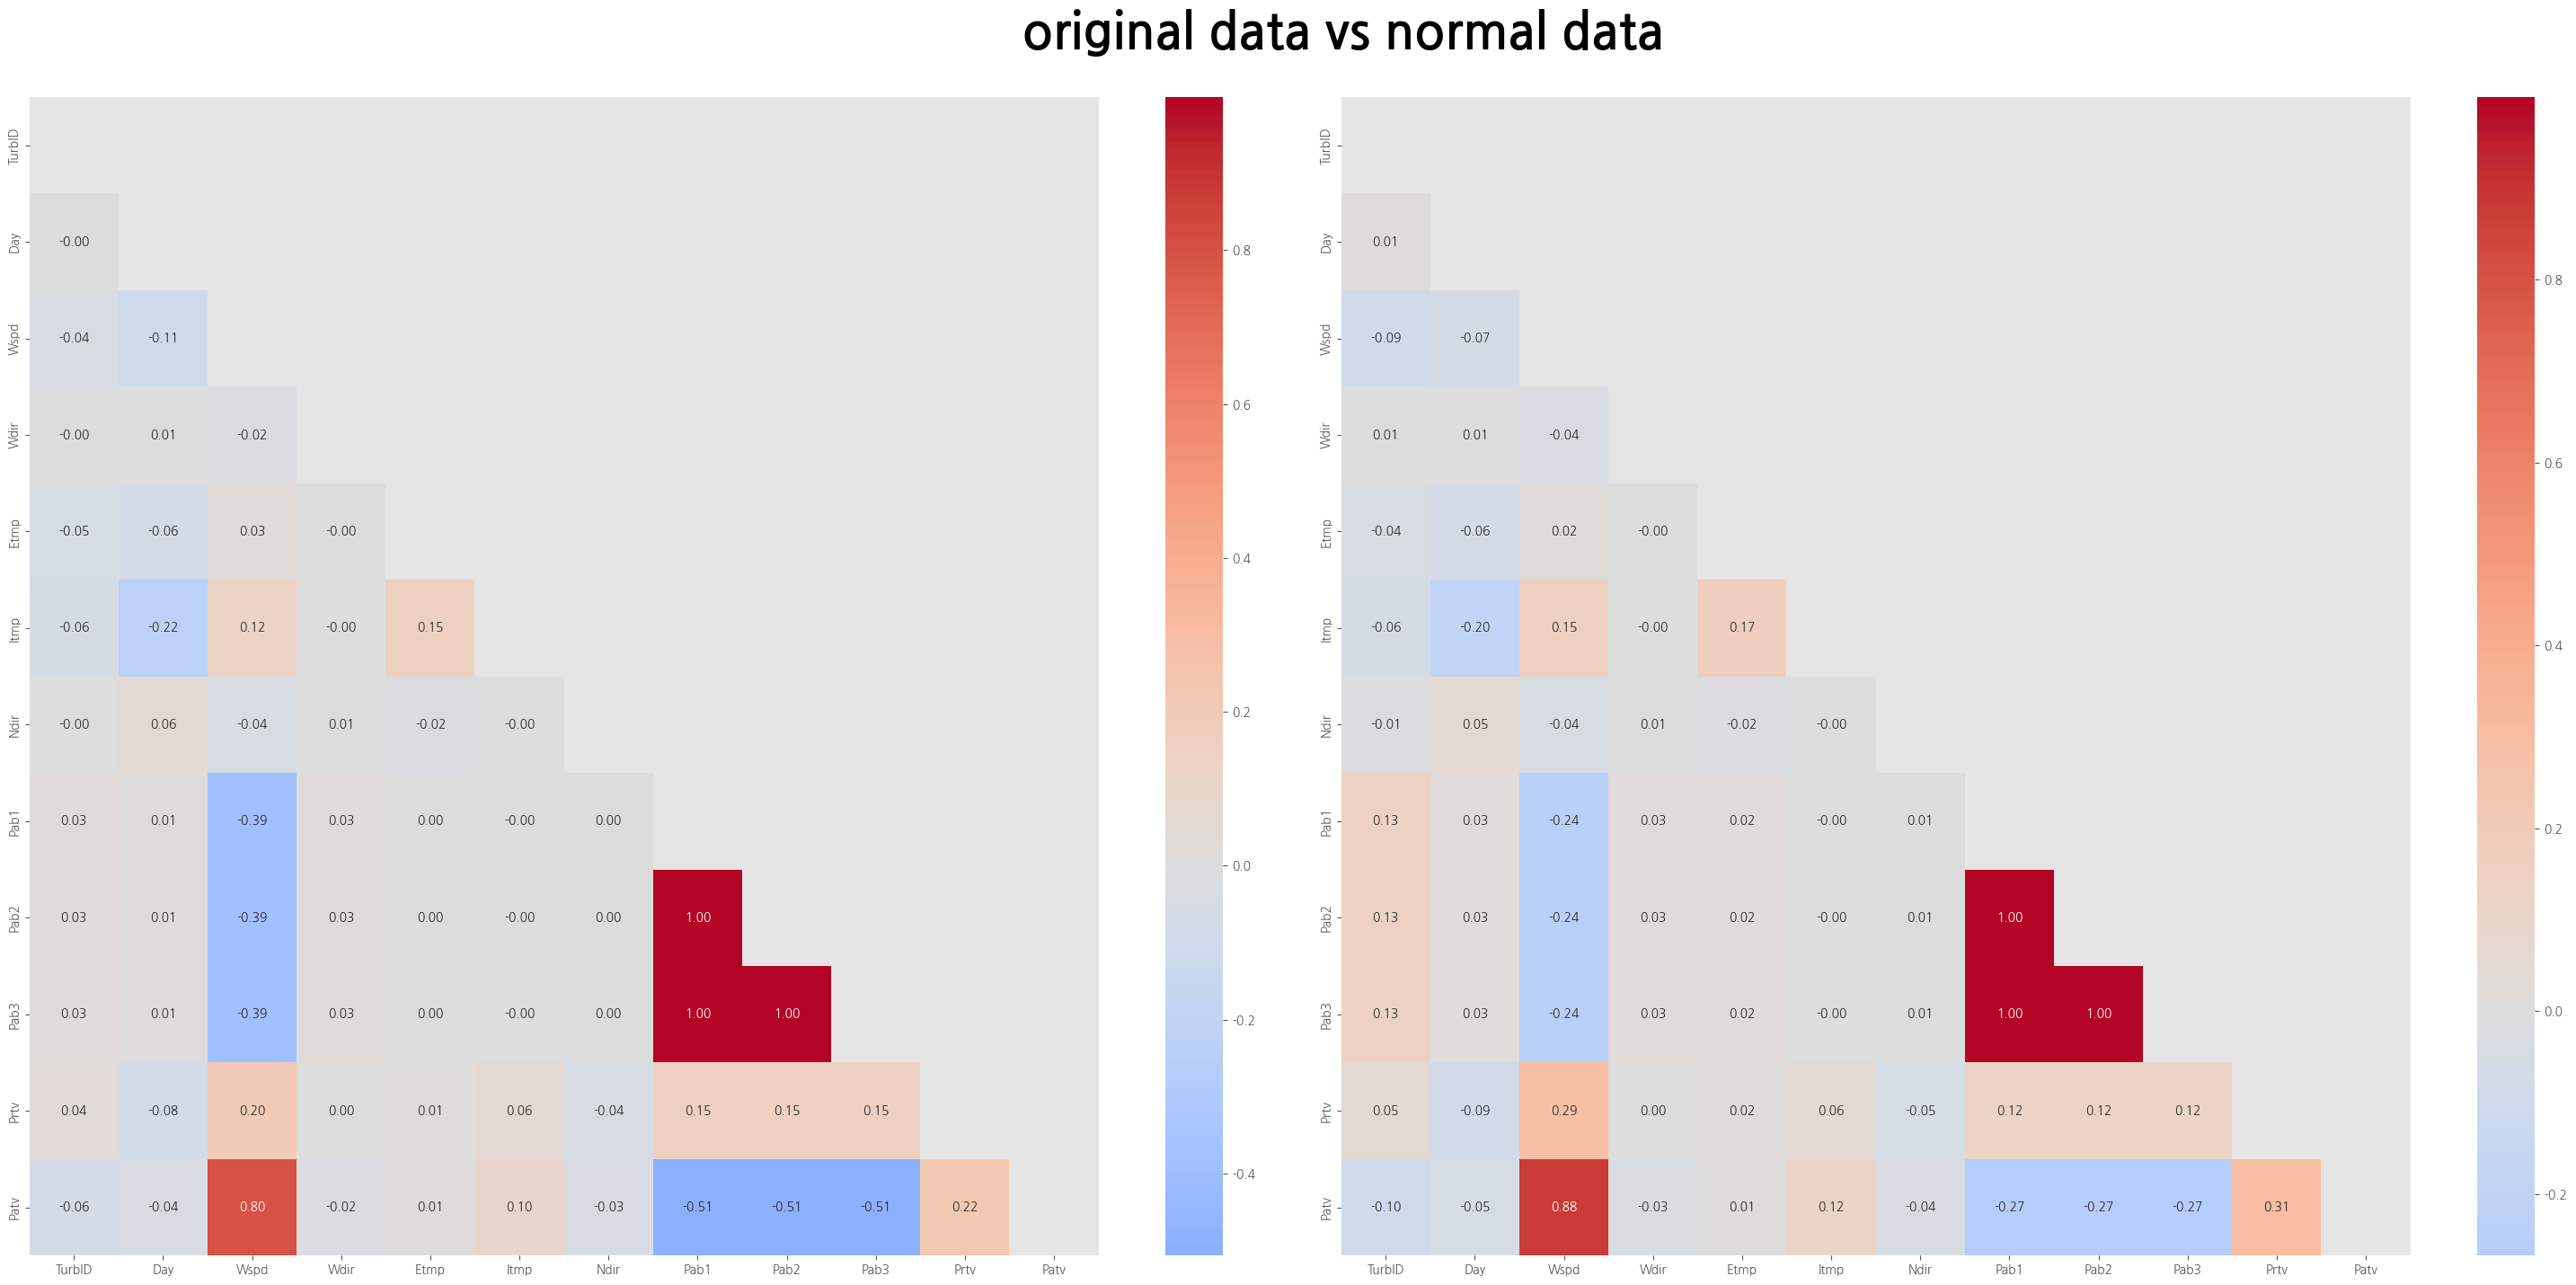

In [11]:
eda.plot_corr(train.corr(), train2_normal.drop(['Time'], axis=1).corr(), title='original data vs normal data')

- abnormal value를 가진 데이터를 제거해준 뒤, corr(Wspd, Patv) 값이 0.79에서 0.88로 오른 것이 확인됨
- 날개 각도가 바람의 힘을 받지 못한 경우를 제거해준 영향으로 판단

# 5. Etmp, Itmp handling

- Etmp : -20 ~ 80 안에 들도록 clipping
- Itmp : -10 ~ 65 안에 들도록 clipping

In [12]:
def manual_handling(data):
    def mark(data, col, min_val, max_val):
        data.loc[(data[col] < min_val) | (max_val < data[col]), col] = None

    data = copy(data)
    mark(data, 'Etmp', -20, 80)
    mark(data, 'Itmp', -10, 65)
    
    data.loc[(data['TurbID'] == 2) & (7533 <= data['Time']) & (data['Time'] <= 7899), 'Etmp']   = None
    data.loc[(data['TurbID'] == 2) & (24408 <= data['Time']) & (data['Time'] <= 24414), 'Etmp'] = None
    data.loc[(data['TurbID'] == 2) & (26562 <= data['Time']) & (data['Time'] <= 26575), 'Etmp'] = None
    
    return data

In [13]:
train3 = manual_handling(train2)

# 6. Outlier handling

In [14]:
def outlier_handling(data, columns):
    @delayed
    def task(data_tid, window_size):
        for day in data_tid['Day'].unique():
            for column in columns:
                temp = data_tid.loc[(day <= data_tid['Day']) & (data_tid['Day'] <= day + window_size - 1), [column]]
                temp[f'{column}_diff'] = temp[column].diff(1)
                for col in (column, f'{column}_diff'):
                    stats = boxplot_stats(temp.dropna()[col])[0]
                    temp[col].where((stats['whislo'] <= temp[col]) & (temp[col] <= stats['whishi']), np.nan, inplace=True)
                temp.drop(columns=[f'{column}_diff'], inplace=True)
                data_tid.loc[temp.index, [column]] = temp.values
        return data_tid
    
    data = data.copy()
    tasks = [task(data[data['TurbID'] == turbID], window_size=2) for turbID in data['TurbID'].unique()]
    with ProgressBar():
        data_tids = compute(*tasks, scheduler='processes')
    
    for data_tid in tqdm(data_tids):
        data.loc[data_tid.index] = data_tid.values
    
    return data

In [15]:
train4 = outlier_handling(train3, ['Etmp', 'Itmp'])

[########################################] | 100% Completed | 32.3s


100%|██████████| 134/134 [00:57<00:00,  2.31it/s]


# 6. Data imputation

In [16]:
def find_neighbor(data, col, my_TurbID, plot=False):
    df = pd.DataFrame()
    for turbID in data['TurbID'].unique():
        df[turbID] = data[data['TurbID'] == turbID][col].values
    res = df - df[[my_TurbID]].values
    mae = res.abs().mean()
    rst = mae.drop(my_TurbID).idxmin()
    if plot:
        fig, (ax1, ax2) = plt.subplots(2, figsize=(40, 5))
        mae.sort_values().plot.bar(ax=ax1)
        df[[my_TurbID, rst]].plot(ax=ax2)

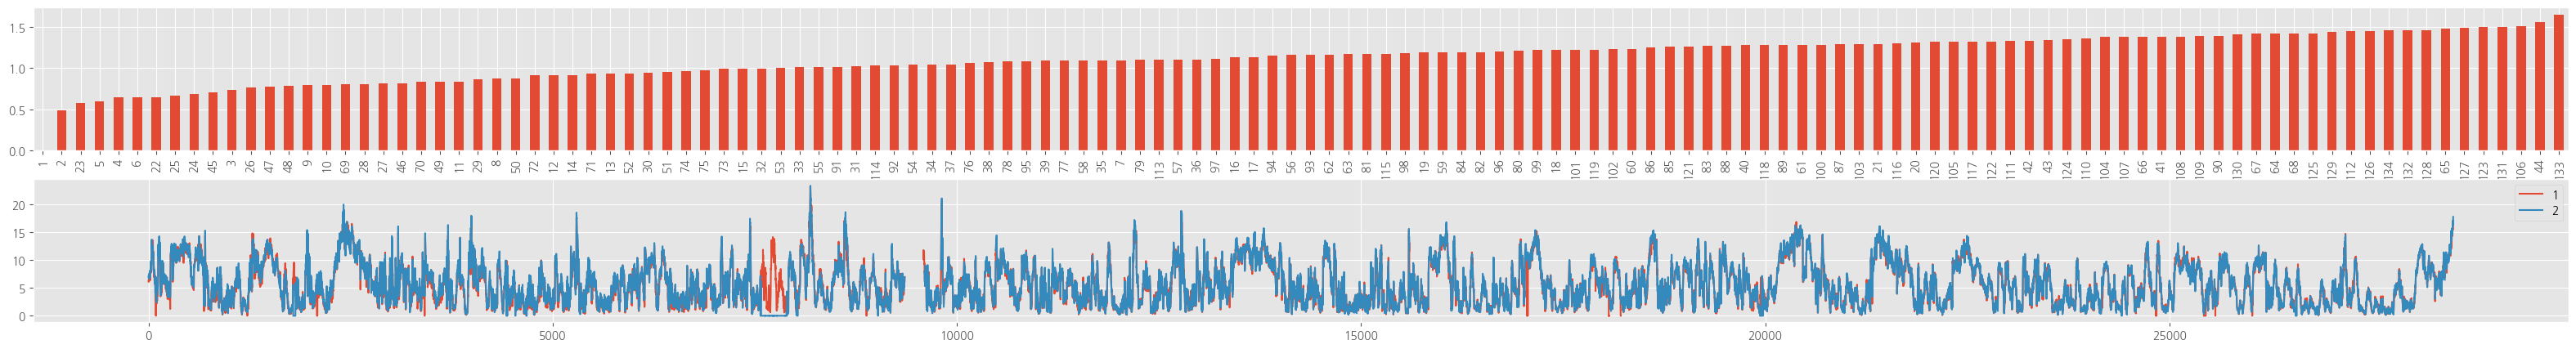

In [17]:
find_neighbor(train4, 'Wspd', 1, plot=True)

- 특정 feature와 TurbID 대해 나머지 모든 TurbID와 MAE를 계산 후 정렬
- 가장 가까운 TurbID와 기준 TurbID의 feature 값 plot

### 6-1. Greedy imputing

- 1. Imputing하고자 하는 Target TurbID(터빈)과 가장 가까운 k개 TurbID(터빈) 선택
- 2. 선택된 가장 가까운 k개 터빈들을 Target TurbID의 값과 비교하여(MAE or MSE) 유사한 순으로 정렬
- 3. 가장 가까운 터빈의 값을 골라 Target TurbID의 값으로 채워넣음
- 4. 가장 가까운 터빈의 값이 비어 있을 경우 다음으로 가까운 터빈의 값을 채움

In [18]:
def get_dists_loc(input_path):
    from sklearn.metrics.pairwise import euclidean_distances

    loc = pd.read_csv(input_path).set_index('TurbID')
    tids = loc.index
    dists_loc = np.full((len(loc)+1, len(loc)+1), np.inf)
    for i1 in range(len(loc)-1):
        for i2 in range(i1+1, len(loc)):
            t1, t2 = tids[i1], tids[i2]
            dists_loc[i1, i2] = euclidean_distances([loc.loc[t1].values], [loc.loc[t2].values])
    return dists_loc

def greedy_imputing(data, tids=None, k=10, path=None, verbose=False):
    def greedy_imputing_tid(data, tid_target, dists_loc, k, verbose):
        def affinity(tid):
            d        = data[data['TurbID'] == tid][cols].values
            d_target = data[data['TurbID'] == tid_target][cols].values
            diff = np.abs(d - d_target)
            return diff[~np.isnan(diff)].mean()
        
        cols       = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab1', 'Pab2', 'Pab3', 'Prtv', 'Patv']
        neighbors  = [tid for tid, dist_loc in sorted(enumerate(dists_loc[tid_target], start=1), key=lambda x: x[1])[:k]]
        n_nan_prev = np.sum(data.loc[data['TurbID'] == tid_target, cols].isna().values)

        for tid in sorted(neighbors, key=affinity):
            a = data.loc[data['TurbID'] == tid_target, cols].values
            b = data.loc[data['TurbID'] == tid, cols].values
            data.loc[data['TurbID'] == tid_target, cols] = np.where(np.isnan(a) & (~np.isnan(b)), b, a)

        n_nan_after = np.sum(data[data['TurbID'] == tid_target].isna().values)
        if verbose and n_nan_after < n_nan_prev:
            print(f"[TurbID {tid_target}] Number of nan: {n_nan_prev} -> {n_nan_after}")
        return n_nan_after < n_nan_prev

    data = copy(data)
    dists_loc = get_dists_loc(path)

    if tids is None:
        tids = data['TurbID'].unique()

    while True:
        rsts = {}
        for tid in tqdm(tids):
            rsts[tid] = greedy_imputing_tid(data, tid, dists_loc, k, verbose)
        if not any(rsts.values()) or (k == 134):
            break

    return data

In [19]:
tids=[2, 7, 8, 9, 13, 18, 24, 25, 26, 29, 30, 33, 36, 38, 40, 41, 50, 54, 60, 
      61, 65, 66, 67, 68, 79, 80, 82, 87, 88, 105, 118, 121, 122, 126, 129]
path = '../../data/turb_location.CSV'

train5 = greedy_imputing(train4, tids=tids, k=20, path=path)

100%|██████████| 35/35 [01:34<00:00,  2.70s/it]


### 6-2. Linear interpolation

- 데이터가 연속적으로 비어있는 부분이 존재
- 각 터빈에 대해 threshold(12 hours) 이하 missing value 구간에 대해서만 linear interpolation으로 채움
- 너무 긴 sequence를 무리하게 interpolation하면 시계열 특성이 망가질 우려가 있음

In [20]:
def impute_data(data, threshold=6 * 12, drop=False):
    data = copy(data)
    data_imp = pd.DataFrame()
    for turbID in tqdm(data['TurbID'].unique()):
        data_tid = data[data['TurbID'] == turbID]
        idxs = (data_tid.isna().sum(axis='columns') > 0)
        idxs_nan = idxs[idxs].index
        idxs_removed = []

        if len(idxs_nan) > 0:
            s, e = 0, 1
            while e < len(idxs_nan):
                cur = idxs_nan[s:e]
                if idxs_nan[e] == cur[-1] + 1:
                    e += 1
                else:
                    if len(cur) >= threshold:
                        idxs_removed += list(cur)
                    s = e
                    e = s + 1
            else:
                if len(cur) >= threshold:
                    idxs_removed += list(cur)

        data_tid_drop = data_tid.drop(idxs_removed)
        tmp = data.isna().sum()
        cols_nan = tmp[tmp > 0].index
        data_tid_drop[cols_nan] = data_tid_drop[cols_nan].interpolate().bfill().ffill()
        if drop:
            data_tid_imp = data_tid_drop
        else:
            data_tid_imp = data_tid
            data_tid_imp.loc[data_tid_drop.index] = data_tid_drop.values
        data_imp = data_imp.append(data_tid_imp)

    return data_imp.reset_index(drop=True)

In [21]:
train6 = impute_data(train5)

100%|██████████| 134/134 [01:04<00:00,  2.09it/s]


- 최종 imputing 결과

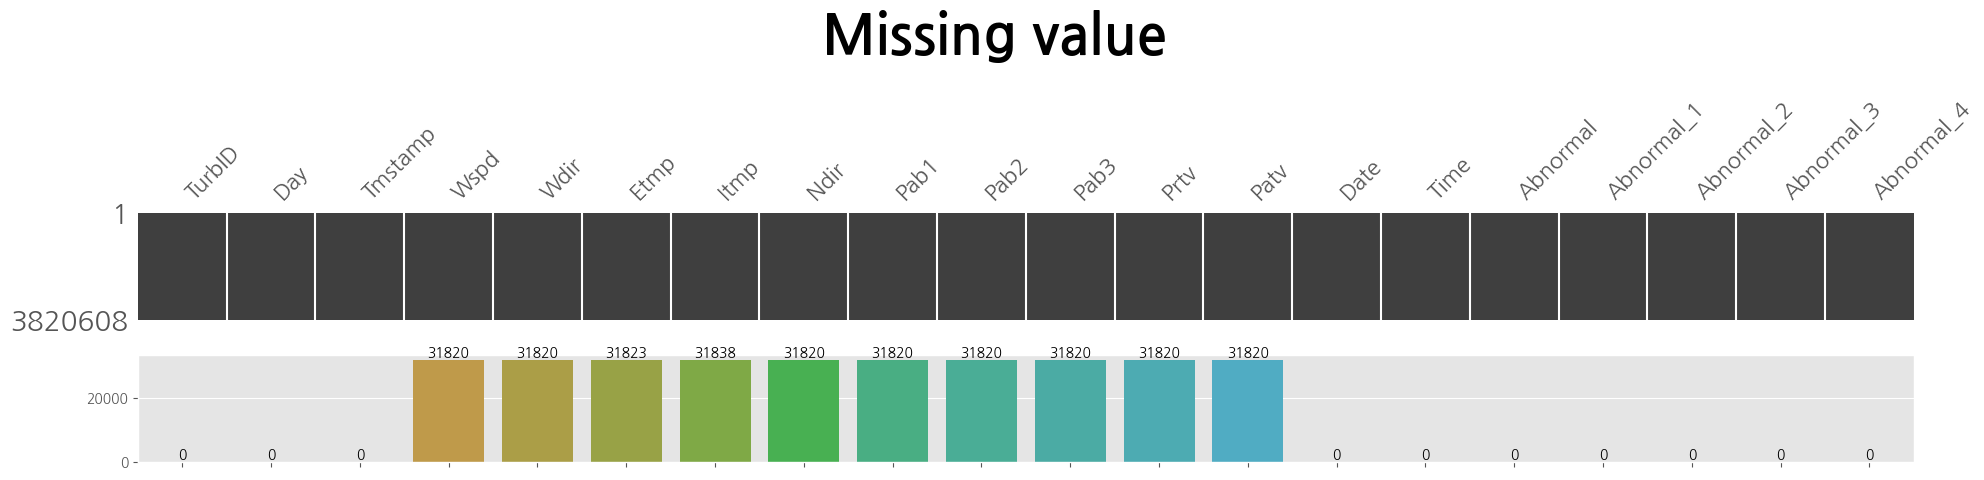

In [22]:
import matplotlib as mpl
eda.plot_missing_value(train6, figsize=(20, 5))

In [23]:
for tid in train6['TurbID'].unique():
    data = train6.query(f"TurbID == {tid}")
    data_nan = data[data.isna().any(1)]
    
    print("TurbID:", tid)
    display(data_nan.groupby("Day").count()['Time'].to_frame().T.style.background_gradient(axis=1))

TurbID: 1


Day,65,66,67
Time,4,144,81


TurbID: 2


Day,65,66,67
Time,3,144,80


TurbID: 3


Day,65,66,67
Time,16,144,81


TurbID: 4


Day,65,66,67
Time,9,144,92


TurbID: 5


Day,65,66,67
Time,4,144,81


TurbID: 6


Day,65,66,67
Time,14,144,103


TurbID: 7


Day,65,66,67
Time,3,144,80


TurbID: 8


Day,65,66,67
Time,3,144,80


TurbID: 9


Day,65,66,67
Time,3,144,80


TurbID: 10


Day,65,66,67
Time,9,144,96


TurbID: 11


Day,65,66,67
Time,14,144,81


TurbID: 12


Day,65,66,67
Time,6,144,80


TurbID: 13


Day,65,66,67
Time,3,144,80


TurbID: 14


Day,65,66,67
Time,11,144,96


TurbID: 15


Day,65,66,67
Time,10,144,87


TurbID: 16


Day,65,66,67
Time,5,144,81


TurbID: 17


Day,65,66,67
Time,10,144,81


TurbID: 18


Day,65,66,67
Time,3,144,80


TurbID: 19


Day,65,66,67
Time,4,144,98


TurbID: 20


Day,65,66,67
Time,9,144,97


TurbID: 21


Day,65,66,67
Time,9,144,97


TurbID: 22


Day,65,66,67
Time,11,144,86


TurbID: 23


Day,65,66,67
Time,11,144,102


TurbID: 24


Day,65,66,67
Time,3,144,80


TurbID: 25


Day,65,66,67
Time,3,144,80


TurbID: 26


Day,65,66,67
Time,3,144,80


TurbID: 27


Day,65,66,67
Time,11,144,96


TurbID: 28


Day,65,66,67
Time,11,144,86


TurbID: 29


Day,65,66,67
Time,3,144,80


TurbID: 30


Day,65,66,67
Time,3,144,80


TurbID: 31


Day,65,66,67
Time,16,144,80


TurbID: 32


Day,65,66,67
Time,6,144,80


TurbID: 33


Day,65,66,67
Time,3,144,80


TurbID: 34


Day,65,66,67
Time,11,144,91


TurbID: 35


Day,65,66,67
Time,16,144,80


TurbID: 36


Day,65,66,67
Time,3,144,80


TurbID: 37


Day,65,66,67
Time,11,144,91


TurbID: 38


Day,65,66,67
Time,3,144,80


TurbID: 39


Day,65,66,67
Time,6,144,80


TurbID: 40


Day,65,66,67
Time,3,144,80


TurbID: 41


Day,65,66,67
Time,3,144,80


TurbID: 42


Day,65,66,67
Time,6,144,80


TurbID: 43


Day,65,66,67
Time,6,144,100


TurbID: 44


Day,65,66,67
Time,6,144,80


TurbID: 45


Day,65,66,67
Time,16,144,80


TurbID: 46


Day,65,66,67
Time,6,144,84


TurbID: 47


Day,65,66,67
Time,6,144,80


TurbID: 48


Day,65,66,67
Time,11,144,86


TurbID: 49


Day,65,66,67
Time,11,144,91


TurbID: 50


Day,65,66,67
Time,3,144,80


TurbID: 51


Day,65,66,67
Time,11,144,91


TurbID: 52


Day,65,66,67
Time,14,144,80


TurbID: 53


Day,65,66,67
Time,16,144,80


TurbID: 54


Day,65,66,67
Time,3,144,80


TurbID: 55


Day,65,66,67
Time,6,144,80


TurbID: 56


Day,65,66,67
Time,6,144,80


TurbID: 57


Day,65,66,67
Time,16,144,80


TurbID: 58


Day,65,66,67
Time,6,144,101


TurbID: 59


Day,65,66,67
Time,16,144,81


TurbID: 60


Day,65,66,67
Time,3,144,80


TurbID: 61


Day,65,66,67
Time,3,144,80


TurbID: 62


Day,65,66,67
Time,6,144,80


TurbID: 63


Day,65,66,67
Time,15,144,91


TurbID: 64


Day,65,66,67
Time,6,144,91


TurbID: 65


Day,65,66,67
Time,3,144,80


TurbID: 66


Day,65,66,67
Time,3,144,80


TurbID: 67


Day,65,66,67
Time,3,144,80


TurbID: 68


Day,65,66,67
Time,3,144,80


TurbID: 69


Day,65,66,67
Time,14,144,81


TurbID: 70


Day,65,66,67
Time,5,144,97


TurbID: 71


Day,65,66,67
Time,4,144,92


TurbID: 72


Day,65,66,67
Time,4,144,81


TurbID: 73


Day,65,66,67
Time,9,144,97


TurbID: 74


Day,65,66,67
Time,14,144,81


TurbID: 75


Day,65,66,67
Time,9,144,81


TurbID: 76


Day,65,66,67
Time,4,144,102


TurbID: 77


Day,65,66,67
Time,3,144,81


TurbID: 78


Day,65,66,67
Time,9,144,81


TurbID: 79


Day,65,66,67
Time,3,144,80


TurbID: 80


Day,65,66,67
Time,3,144,80


TurbID: 81


Day,65,66,67
Time,4,144,112


TurbID: 82


Day,65,66,67
Time,3,144,80


TurbID: 83


Day,65,66,67
Time,5,144,97


TurbID: 84


Day,65,66,67
Time,4,144,82


TurbID: 85


Day,65,66,67
Time,4,144,102


TurbID: 86


Day,65,66,67
Time,9,144,97


TurbID: 87


Day,65,66,67
Time,3,144,80


TurbID: 88


Day,65,66,67
Time,3,144,80


TurbID: 89


Day,65,66,67
Time,9,144,97


TurbID: 90


Day,65,66,67
Time,14,144,81


TurbID: 91


Day,65,66,67
Time,9,144,88


TurbID: 92


Day,65,66,67
Time,13,144,82


TurbID: 93


Day,65,66,67
Time,13,144,93


TurbID: 94


Day,65,66,67
Time,3,144,89


TurbID: 95


Day,65,66,67
Time,8,144,93


TurbID: 96


Day,65,66,67
Time,8,144,98


TurbID: 97


Day,65,66,67
Time,8,144,94


TurbID: 98


Day,65,66,67
Time,8,144,82


TurbID: 99


Day,65,66,67
Time,3,144,82


TurbID: 100


Day,65,66,67
Time,3,144,89


TurbID: 101


Day,65,66,67
Time,3,144,90


TurbID: 102


Day,65,66,67
Time,4,144,102


TurbID: 103


Day,65,66,67
Time,9,144,81


TurbID: 104


Day,65,66,67
Time,4,144,88


TurbID: 105


Day,65,66,67
Time,3,144,80


TurbID: 106


Day,65,66,67
Time,19,144,81


TurbID: 107


Day,65,66,67
Time,9,144,82


TurbID: 108


Day,65,66,67
Time,24,144,88


TurbID: 109


Day,65,66,67
Time,3,144,82


TurbID: 110


Day,65,66,67
Time,19,144,88


TurbID: 111


Day,65,66,67
Time,9,144,102


TurbID: 112


Day,65,66,67
Time,3,144,113


TurbID: 113


Day,65,66,67
Time,3,144,108


TurbID: 114


Day,65,66,67
Time,13,144,83


TurbID: 115


Day,65,66,67
Time,8,144,98


TurbID: 116


Day,65,66,67
Time,13,144,83


TurbID: 117


Day,65,66,67
Time,3,144,89


TurbID: 118


Day,65,66,67
Time,3,144,80


TurbID: 119


Day,65,66,67
Time,3,144,89


TurbID: 120


Day,65,66,67
Time,8,144,83


TurbID: 121


Day,65,66,67
Time,3,144,80


TurbID: 122


Day,65,66,67
Time,3,144,80


TurbID: 123


Day,65,66,67
Time,8,144,99


TurbID: 124


Day,65,66,67
Time,8,144,82


TurbID: 125


Day,65,66,67
Time,3,144,89


TurbID: 126


Day,65,66,67
Time,3,144,80


TurbID: 127


Day,65,66,67
Time,3,144,89


TurbID: 128


Day,65,66,67
Time,3,144,82


TurbID: 129


Day,65,66,67
Time,3,144,80


TurbID: 130


Day,65,66,67
Time,8,144,108


TurbID: 131


Day,65,66,67
Time,4,144,93


TurbID: 132


Day,65,66,67
Time,13,144,82


TurbID: 133


Day,65,66,67
Time,3,144,82


TurbID: 134


Day,65,66,67
Time,13,144,99


- 특정 세 날짜(Day 65, 66, 67)에 모든 missing value 존재

# 7. Feature Extraction

In [24]:
def feature_engineering(data):
    data = copy(data)
    
    # 1. Dummy variables(insight from EDA)
    data['Wspd_extreme'] = data['Wspd'] < 1
    data['Wdir_extreme'] = data['Wdir'].abs() >10
    data['Ndir_extreme'] = data['Ndir'] < -90
    data['Pab']          = (data['Pab1'] + data['Pab2'] + data['Pab3'])/3
    data['Pab_extreme1'] = data['Pab'] < 0.03
    data['Pab_extreme2'] = data['Pab'] > 20
    data['Prtv_pos']     = data['Prtv'] > 0
    
    # 2. Multiplicative variables(interactive effect)
    data['Wspd_active']  = data['Wspd'] - 1
    data['Wdir_active']  = data['Wdir'].abs() - 10
    Ndir_rad             = data['Ndir']
    data['Ndir_cos_abs'] = np.abs(np.cos(Ndir_rad))
    data['Prtv_abs']     = data['Prtv'].abs()
    
    data['Prtv_comb']    = data['Prtv_pos'] * data['Prtv_abs']
    data['Ndir_comb']    = data['Ndir_extreme'] * data['Ndir_cos_abs']
    data['Wdir_comb']    = data['Wdir_extreme'] * data['Wdir_active']
    data['Wspd_comb']    = data['Wspd_extreme'] * data['Wspd_active']
    
    # 3. Domain kwonledge
    ALPHA = 40
    Pab_rad     = np.radians(data['Pab']+ALPHA)
    data['TSR'] = 1 / np.tan(Pab_rad)
    data['RPM'] = data['Wspd_active'] * data['TSR']    
    data['Wspd_cube'] = data['Wspd_active']**3
    min_val = data[data['Patv'] > 0]['Patv'].min()
    data['Patv_pos']  = np.maximum(data['Patv'], min_val)
    data['Patan_abs'] = np.arctan(data['Prtv_abs'] / data['Patv_pos'])
    
    Wdir_rad         = np.radians(data['Wdir'])
    data['Wdir_cos'] = np.cos(Wdir_rad)
    data['Wdir_sin'] = np.sin(Wdir_rad)
    data['Wspd_cos'] = data['Wspd_active'] * np.cos(Wdir_rad)
    data['Wspd_sin'] = data['Wspd_active'] * np.sin(Wdir_rad)
    data['Ndir_cos'] = np.cos(Ndir_rad)
    data['Ndir_sin'] = np.sin(Ndir_rad)
    
    # 2. Time encoding
    DAY = 6*24  # 10minute * 6 * 24hour
    Time_in_day     = data['Time'] * (2*np.pi) / DAY
    data['Day_cos'] = np.cos(Time_in_day)
    data['Day_sin'] = np.sin(Time_in_day)

    YEAR = 365*DAY
    Time_in_year     = data['Time'] * (2*np.pi) / YEAR
    data['Year_cos'] = np.cos(Time_in_year)
    data['Year_sin'] = np.sin(Time_in_year)
    data['Weekday']  = data['Day'] % 7
    
    return data

def feature_engineering_lag(data, cols, lags):
    data = copy(data)
    for turbID in tqdm(data['TurbID'].unique()):
        data_tid = data[data['TurbID'] == turbID]
        for lag in lags:
            data.loc[data_tid.index, [f'{col}_LAG{lag}' for col in cols]] = data_tid[cols].shift(144*lag).values
            
    data = data[data['Day'] > max(lags)]
    return data

In [25]:
train_fe = feature_engineering(train6)

In [27]:
target = 'Patv'
col_sel = ['Wspd', 'Wdir', 'Etmp', 'Itmp', 'Ndir', 'Pab', 'Prtv', 'RPM', target]

train_fe_with_lag = feature_engineering_lag(train_fe, col_sel, lags=[5])

100%|██████████| 134/134 [00:15<00:00,  8.93it/s]


In [28]:
train_fe.to_csv('../../data/train_fe.csv', index=False)
train_fe_with_lag.to_csv('../../data/train_fe_with_lag.csv', index=False)

In [29]:
test.to_csv('../../data/test.csv', index=False)